In [24]:
import os
import sys
import json
import xmltodict
import datetime
import numpy as np
import skimage.draw
from mrcnn.config import Config
import mrcnn.model as modellib
from mrcnn import utils
from mrcnn import visualize

from pycocotools.coco import COCO
import trees as TreeConfig
import trees

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "weights", "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
MODEL_DIR = os.path.join(ROOT_DIR, 'mask_rcnn', 'logs')
TREE_DIR = os.path.join(ROOT_DIR, 'trees')

In [25]:
config = trees.TreeConfig()

In [26]:
# Load dataset
dataset = trees.TreeDataset()

In [27]:
dataset.load_tree(TREE_DIR, "train")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Images: 29
Classes: ['BG', 'Trees', 'Not Trees']


5


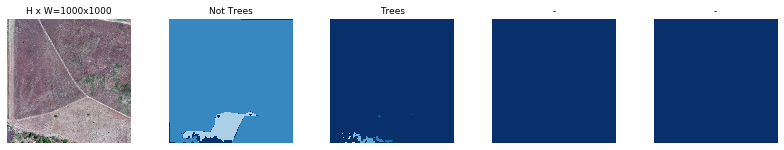

26


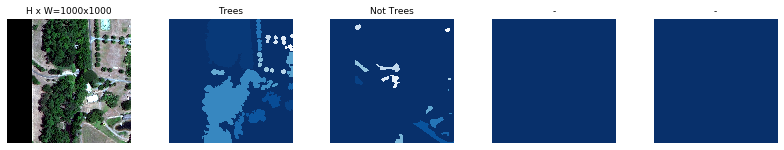

24


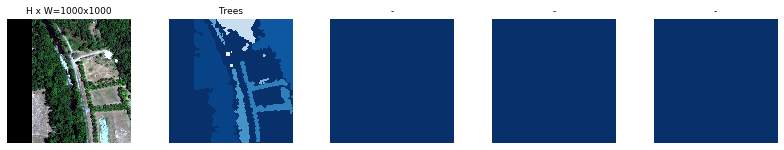

8


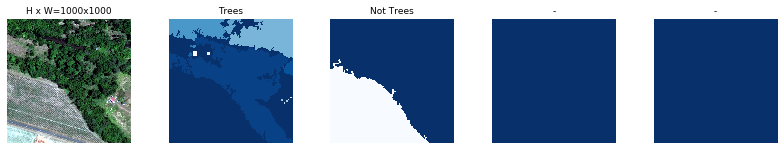

26


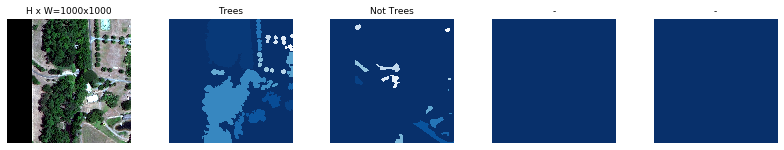

In [28]:

# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 5)
for image_id in image_ids:
    print(image_id)
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)